# Exploratory Analysis

## import csv file from github repository

In [1]:
!pip install pymongo

In [2]:
pip install pandas_profiling

Note: you may need to restart the kernel to use updated packages.


In [1]:
import pandas as pd
import seaborn as sns
import matplotlib
import plotly
import plotly.express as px
import plotly.graph_objects as go
import numpy as np
import statsmodels.api as sm
import sklearn
import os
from sklearn import preprocessing
from matplotlib import pyplot as plt
import warnings
import pandas_profiling
import pymongo
warnings.filterwarnings('ignore')


In [2]:
print(pd.__version__)
print(sns.__version__)
print(matplotlib.__version__)
print(plotly.__version__)
print(np.__version__)
print(sm.__version__)
print(sklearn.__version__)


1.4.4
0.11.2
3.5.2
5.9.0
1.21.5
0.13.2
1.0.2


In [3]:
connessione = pymongo.MongoClient("mongodb://localhost:27017/")
WorldCupDb = connessione["WorldCup"] #crea DB
WorldCupCollection = WorldCupDb["WorldCupDf"] #crea collezione all'interno del db

# Query Nosql

La seguente query seleziona tutte le partite tranne quelle degli stati uniti, questo perchè avendo pochi tweet a disposizione compromette le analisi. Inoltre sono state prese solo determinate colonne

In [4]:

query_projection = {
                  "tipo_di_partita":1,
                  'nome_partita':1,
                  'squadra_in_casa':1,
                  'squadra_in_trasferta':1,
                  'gol_segnati_casa':1,
                  'gol_segnati_trasferta':1,
                  'rigori_finali_segnati_casa':1,
                  'rigori_finali_segnati_trasferta':1,
                  'tiri_totale_casa':1,
                  'tiri_totale_trasferta':1,
                  'tiri_in_porta_casa':1,
                  'tiri_in_porta_trasferta':1,
                  'Negativo':1,
                  'Neutro':1,
                  'Positivo':1,
                  'total_tweets':1,
                  'Punti Rank casa':1,
                  'Punti Rank ospite':1 
}

query={
  "$and": [
    {"squadra_in_casa": {'$ne': "UNITED STATES"}},
    {"squadra_in_trasferta": {'$ne': "UNITED STATES"}}
  ]
}

query_result = WorldCupCollection.find(query,query_projection)
query_result

In [5]:
dataset=[]
for i in query_result:
    dataset.append(i)
    
complete_df0=pd.DataFrame(dataset)

# DF_to_csv

In [6]:
complete_df0.to_csv(path_or_buf=os.path.join(
                    r"C:\Users\Utente\Desktop\Progetto DataMan\CSV", 'complete_df.csv')
               ,sep=";"
               ,header=True
               ,index=False
              )

In [8]:
complete_df0.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60 entries, 0 to 59
Data columns (total 19 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   _id                              60 non-null     object 
 1   tipo_di_partita                  60 non-null     object 
 2   squadra_in_casa                  60 non-null     object 
 3   squadra_in_trasferta             60 non-null     object 
 4   gol_segnati_casa                 60 non-null     int64  
 5   gol_segnati_trasferta            60 non-null     int64  
 6   rigori_finali_segnati_casa       60 non-null     int64  
 7   rigori_finali_segnati_trasferta  60 non-null     int64  
 8   nome_partita                     60 non-null     object 
 9   tiri_totale_casa                 60 non-null     int64  
 10  tiri_totale_trasferta            60 non-null     int64  
 11  tiri_in_porta_casa               60 non-null     int64  
 12  tiri_in_porta_trasferta 

In [11]:
def gironi_iniziali_function(x):
    if x.startswith('Group'):
        y = 'Group'
    else:
        y = x
    return y

# cambio nome partita per le partite dei gironi iniziali
complete_df0['tipo_di_partita_nuovo'] = complete_df0[
                        'tipo_di_partita'].apply(lambda x:gironi_iniziali_function(x))

complete_df0[['tipo_di_partita_nuovo']].head(5)

,tipo_di_partita_nuovo
0,Group
1,Group
2,Group
3,Group
4,Group


In [12]:
# percentuale tweets positivi (il denominatore è la somma tra tweets negativipos, neutri e positivi)
complete_df0['percentuale_tweets_positivi'] = complete_df0[
                            'Positivo'] /  (complete_df0['total_tweets']) * 100
complete_df0['percentuale_tweets_positivi'] = complete_df0[
                'percentuale_tweets_positivi'].apply(lambda x:round(x,2))

# numero totale di gol segnati durante la partita (gol segnati nei 90 o 120 min di gioco e ai rigori finali)
complete_df0['gol_totali'] = complete_df0[
                            'gol_segnati_casa'] + complete_df0[
                            'gol_segnati_trasferta'] 
# somma dei punteggi ranking FIFA delle due squadre nazionale che hanno giocato nei vari incontri del torneo
complete_df0['punti_ranking_totali'] = complete_df0[
                            'Punti Rank casa'] + complete_df0[
                            'Punti Rank ospite']


#somma tiriin porta totali

complete_df0['tiri_porta_totali'] = complete_df0[
                            'tiri_in_porta_casa'] + complete_df0[
                            'tiri_in_porta_trasferta']


In [13]:
col_names_list1 = ['tipo_di_partita_nuovo',
                   'nome_partita',
                   'gol_totali',
                   'tiri_porta_totali',
                   'punti_ranking_totali',
                   'percentuale_tweets_positivi'
                   ]

In [16]:
complete_df2 = complete_df0[col_names_list1]
complete_df2.tail(5)

,tipo_di_partita_nuovo,nome_partita,gol_totali,tiri_porta_totali,punti_ranking_totali,percentuale_tweets_positivi
55,Quarter-final,ENGLAND-FRANCE,3,11,3502.31,45.9
56,Semi-final,ARGENTINA-CROATIA,3,10,3402.80,37.4
57,Semi-final,FRANCE-MOROCCO,2,3,3323.20,40.0
58,Play-off for third place,CROATIA-MOROCCO,3,6,3190.50,65.6
59,Final,ARGENTINA-FRANCE,6,14,3535.50,62.2


In [19]:
report = pandas_profiling.ProfileReport(complete_df2)
report

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

In [20]:
report.to_file('reportQatar2022.html')

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

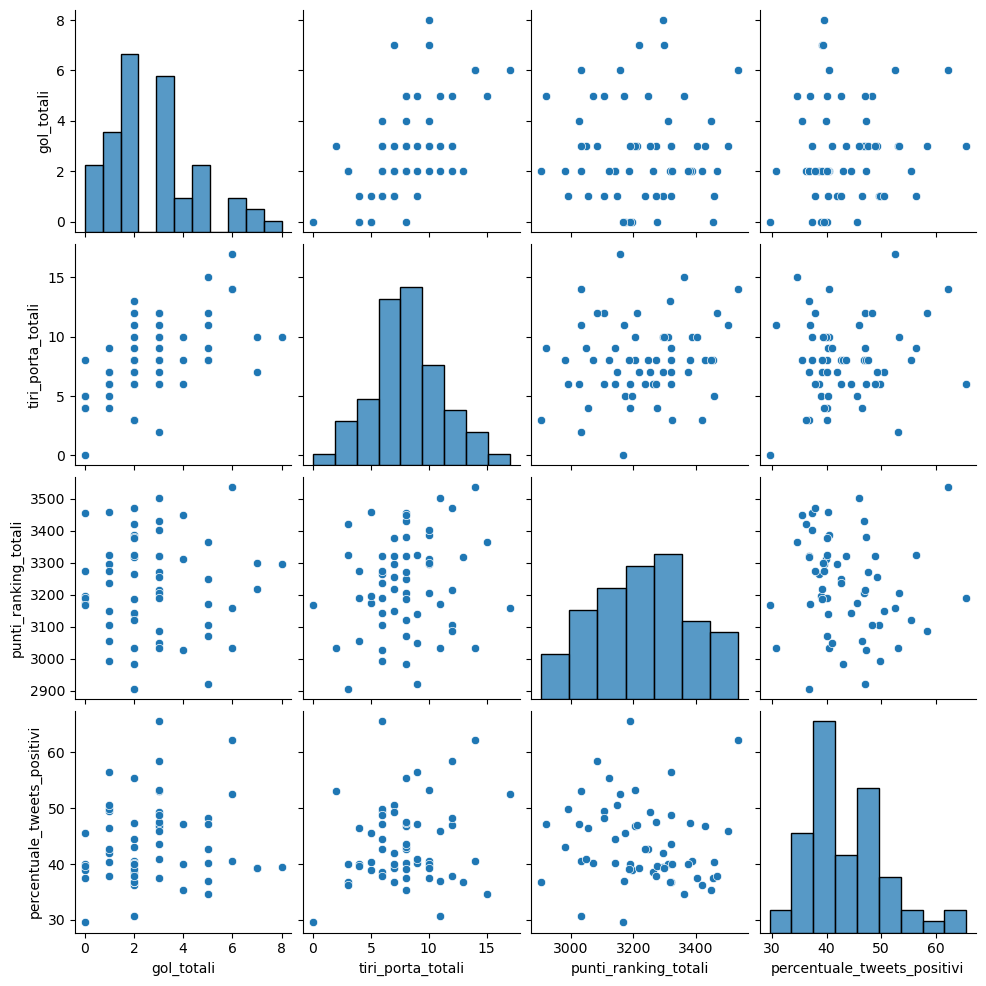

In [17]:
sns.pairplot(complete_df2[['gol_totali',
                           'tiri_porta_totali',
                          'punti_ranking_totali',
                          'percentuale_tweets_positivi']])

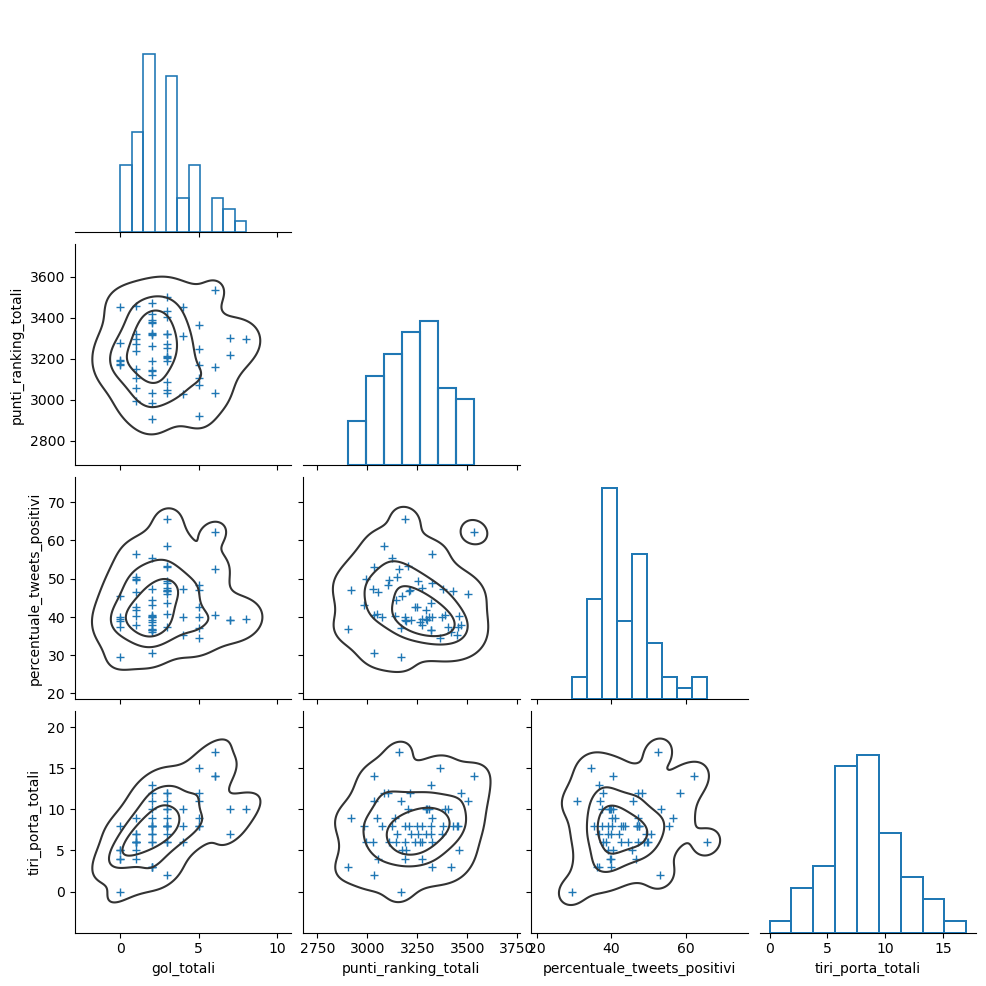

In [18]:
g=sns.pairplot(complete_df2[['gol_totali',
                  'punti_ranking_totali',
                  'percentuale_tweets_positivi',
                  'tiri_porta_totali'
                  #,'tiri_totali'
                            ]],
             corner=True,
             plot_kws=dict(marker="+", linewidth=1),
             diag_kws=dict(fill=False))
g.map_lower(sns.kdeplot, levels=4, color=".2")

plt.show()



In [85]:
complete_df2.describe()

,gol_totali,tiri_porta_totali,punti_ranking_totali,percentuale_tweets_positivi
count,60.000000,60.000000,60.00000,60.000000
mean,3.183333,8.000000,3230.17300,43.662167
std,2.514309,3.288398,149.59512,7.221910
min,0.000000,0.000000,2905.71000,29.520000
25%,2.000000,6.000000,3135.92250,39.075000
50%,3.000000,8.000000,3226.99500,41.400000
75%,4.250000,10.000000,3322.16500,47.350000
max,12.000000,17.000000,3535.50000,65.600000


In [21]:
index00 = complete_df2['gol_totali'].idxmin()
index01 = complete_df2['gol_totali'].idxmax()
index02 = complete_df2['tiri_porta_totali'].idxmin()
index03 = complete_df2['tiri_porta_totali'].idxmax()
index04 = complete_df2['punti_ranking_totali'].idxmin()
index05 = complete_df2['punti_ranking_totali'].idxmax()
index06 = complete_df2['percentuale_tweets_positivi'].idxmin()
index07 = complete_df2['percentuale_tweets_positivi'].idxmax()

index_list = [index00
              ,index01
              ,index02
              ,index03
              ,index04
              ,index05
              ,index06
              ,index07
             ]

complete_df2.iloc[index_list,:].sort_index()

,tipo_di_partita_nuovo,nome_partita,gol_totali,tiri_porta_totali,punti_ranking_totali,percentuale_tweets_positivi
0,Group,QATAR-ECUADOR,2,3,2905.71,36.80
1,Group,ENGLAND-IRAN,8,10,3296.10,39.50
4,Group,DENMARK-TUNISIA,0,5,3173.33,45.50
12,Group,URUGUAY-KOREA,0,0,3166.97,29.52
12,Group,URUGUAY-KOREA,0,0,3166.97,29.52
40,Group,COSTA RICA-GERMANY,6,17,3159.02,52.51
58,Play-off for third place,CROATIA-MOROCCO,3,6,3190.50,65.60
59,Final,ARGENTINA-FRANCE,6,14,3535.50,62.20


In [22]:
min_goals = complete_df2.loc[complete_df2['gol_totali'].idxmin(),
                'nome_partita']

max_goals = complete_df2.loc[complete_df2['gol_totali'].idxmax(),
                'nome_partita']

min_tiri_in_porta = complete_df2.loc[complete_df2['tiri_porta_totali'].idxmin(),
                'nome_partita']

max_tiri_in_porta = complete_df2.loc[complete_df2['tiri_porta_totali'].idxmax(),
                'nome_partita']

min_rank_fifa = complete_df2.loc[complete_df2[
                'punti_ranking_totali'].idxmin(),
                'nome_partita']

max_rank_fifa = complete_df2.loc[complete_df2[
                'punti_ranking_totali'].idxmax(),
                'nome_partita']

min_positive_tweets = complete_df2.loc[complete_df2[
                'percentuale_tweets_positivi'].idxmin(),
                'nome_partita']

max_positive_tweets = complete_df2.loc[complete_df2[
                'percentuale_tweets_positivi'].idxmax(),
                'nome_partita']


print('partita con numero minore di gol: ', min_goals)
print('partita con numero maggiore di gol: ', max_goals)
print('')
print('partita con numero minore di tiri in porta: ', min_tiri_in_porta)
print('partita con numero maggiore di tiri in porta: ', max_tiri_in_porta)
print('')
print('partita con il minore punteggio totale FIFA: ', min_rank_fifa)
print('partita con la maggiore punteggio totale FIFA: ', max_rank_fifa)
print('')
print('partita con la minore percentuale di tweet positivi: ', min_positive_tweets)
print('partita con la maggiore percentuale di tweet positivi: ', max_positive_tweets)

partita con numero minore di gol:  DENMARK-TUNISIA
partita con numero maggiore di gol:  ENGLAND-IRAN

partita con numero minore di tiri in porta:  URUGUAY-KOREA
partita con numero maggiore di tiri in porta:  COSTA RICA-GERMANY

partita con il minore punteggio totale FIFA:  QATAR-ECUADOR
partita con la maggiore punteggio totale FIFA:  ARGENTINA-FRANCE

partita con la minore percentuale di tweet positivi:  URUGUAY-KOREA
partita con la maggiore percentuale di tweet positivi:  CROATIA-MOROCCO


In [23]:
list_df100 = ['gol_totali'
              ,'tiri_porta_totali'
             ,'punti_ranking_totali'
             ,'percentuale_tweets_positivi']

list_df00 = []

for i in list_df100:
    aa = pd.DataFrame(complete_df2[i].describe().apply("{0:.2f}".format))
    list_df00.append(aa)
    
describe_df00 = pd.concat(list_df00, axis=1)
describe_df00  # standardized values for "gol_totali" and "somma_punti_totali_rank_fifa_partita"

,gol_totali,tiri_porta_totali,punti_ranking_totali,percentuale_tweets_positivi
count,60.00,60.00,60.00,60.00
mean,2.75,8.00,3230.17,43.66
std,1.90,3.29,149.60,7.22
min,0.00,0.00,2905.71,29.52
25%,1.75,6.00,3135.92,39.08
50%,2.00,8.00,3226.99,41.40
75%,3.25,10.00,3322.16,47.35
max,8.00,17.00,3535.50,65.60


### Correlation between variables

In [24]:
complete_df2[['gol_totali',
     'tiri_porta_totali',
     'punti_ranking_totali',
     'percentuale_tweets_positivi']].corr()

,gol_totali,tiri_porta_totali,punti_ranking_totali,percentuale_tweets_positivi
gol_totali,1.000000,0.572042,-0.010668,0.106796
tiri_porta_totali,0.572042,1.000000,0.164558,0.142860
punti_ranking_totali,-0.010668,0.164558,1.000000,-0.127815
percentuale_tweets_positivi,0.106796,0.142860,-0.127815,1.000000


## Examples of simple linear regressions

### regression between "percentuale_tweets_positivi" (Y variable) and "punti_ranking_totali" (X variable)

In [25]:
y = complete_df2.percentuale_tweets_positivi

X1 = complete_df2[[#'tiri_porta_totali',
                  'punti_ranking_totali'
        ]]


X1 = sm.add_constant(X1) 

res1 = sm.OLS(y, X1).fit() 
res1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:     percentuale_tweets_positivi   R-squared:                       0.016
Model:                                     OLS   Adj. R-squared:                 -0.001
Method:                          Least Squares   F-statistic:                    0.9633
Date:                         Sat, 14 Jan 2023   Prob (F-statistic):              0.330
Time:                                 11:31:41   Log-Likelihood:                -202.77
No. Observations:                           60   AIC:                             409.5
Df Residuals:                               58   BIC:                             413.7
Df Model:                                    1                                         
Covariance Type:                     nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                   63.5938     20.330      3.128      0.003      22.900     104.288
punti_ranking_totali    -0.0062      0.006     -0.981      0.330      -0.019       0.006
==============================================================================
Omnibus:                       10.042   Durbin-Watson:                   1.932
Prob(Omnibus):                  0.007   Jarque-Bera (JB):                9.810
Skew:                           0.846   Prob(JB):                      0.00741
Kurtosis:                       4.031   Cond. No.                     7.05e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 7.05e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

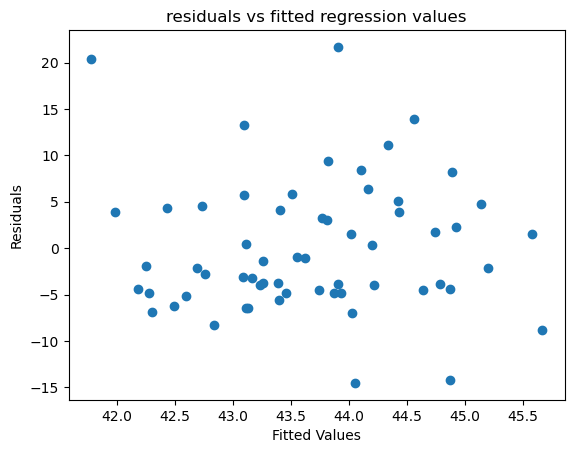

In [26]:
plt.scatter(res1.fittedvalues, res1.resid #,s=area, c=colors, alpha=0.5
            )
plt.title('residuals vs fitted regression values')
plt.xlabel("Fitted Values")
plt.ylabel("Residuals")
plt.show()

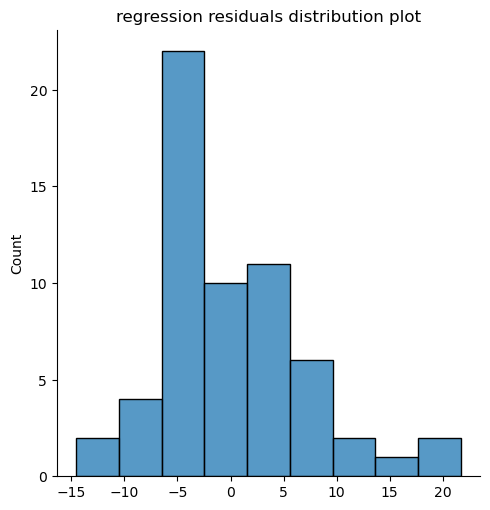

In [36]:
sns.displot(res1.resid).set(title='regression residuals distribution plot')
plt.show()

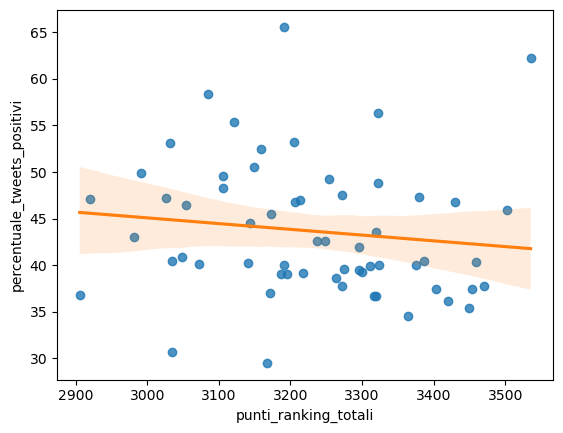

In [37]:
sns.regplot(x='punti_ranking_totali'
            ,y='percentuale_tweets_positivi'
            ,data=complete_df2
            ,line_kws={"color": "C1"}
           )
plt.show()

In [38]:
fig = px.scatter(complete_df2 
                    #,x='gol_totali'
                    ,x='punti_ranking_totali' 
                    ,y='percentuale_tweets_positivi'
                    ,color='tipo_di_partita_nuovo'
                    ,hover_name='nome_partita'
                    #,trendline='ols'
                    #,trendline_color_override='red'
                )
fig.update_traces(marker={'size': 12})
fig.show()

### regression between "percentuale_tweets_positivi" (Y variable) and "tiri_porta_totali" (X variable)

In [39]:
y = complete_df2.percentuale_tweets_positivi

X2 = complete_df2[['tiri_porta_totali'
                  #'punti_ranking_totali'
        ]]


X2 = sm.add_constant(X2) 

res2 = sm.OLS(y, X2).fit() 
res2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:     percentuale_tweets_positivi   R-squared:                       0.020
Model:                                     OLS   Adj. R-squared:                  0.004
Method:                          Least Squares   F-statistic:                     1.208
Date:                         Sat, 14 Jan 2023   Prob (F-statistic):              0.276
Time:                                 11:32:28   Log-Likelihood:                -202.64
No. Observations:                           60   AIC:                             409.3
Df Residuals:                               58   BIC:                             413.5
Df Model:                                    1                                         
Covariance Type:                     nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                41.1522      2.466     16.690      0.000      36.217      46.088
tiri_porta_totali     0.3137      0.285      1.099      0.276      -0.258       0.885
==============================================================================
Omnibus:                        7.503   Durbin-Watson:                   2.009
Prob(Omnibus):                  0.023   Jarque-Bera (JB):                6.685
Skew:                           0.757   Prob(JB):                       0.0353
Kurtosis:                       3.616   Cond. No.                         23.2
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

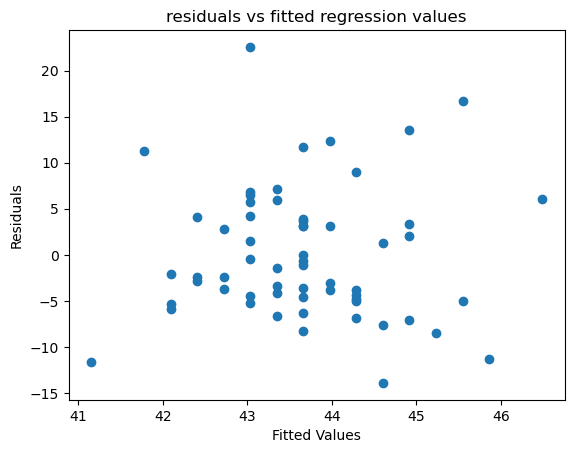

In [40]:
plt.scatter(res2.fittedvalues, res2.resid #,s=area, c=colors, alpha=0.5
            )
plt.title('residuals vs fitted regression values')
plt.xlabel("Fitted Values")
plt.ylabel("Residuals")
plt.show()

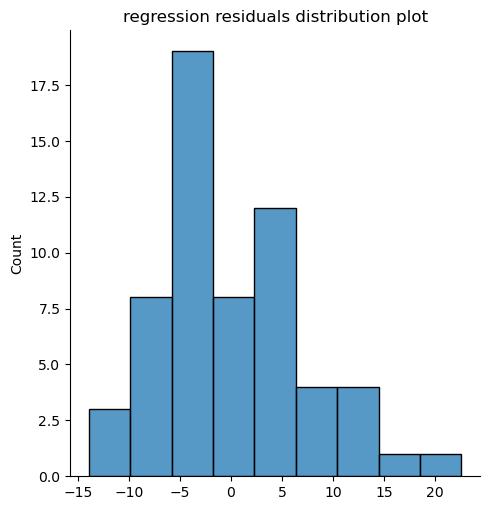

In [41]:
sns.displot(res2.resid).set(title='regression residuals distribution plot')
plt.show()

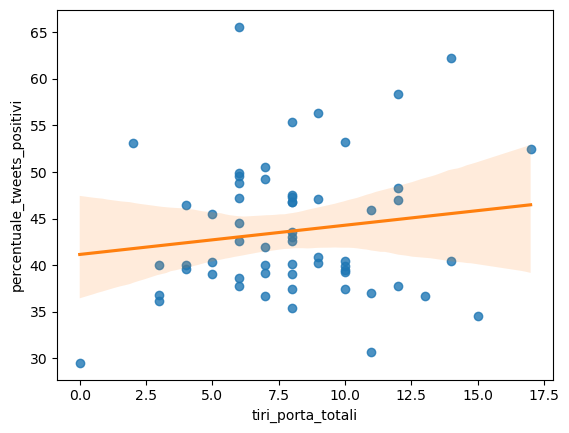

In [42]:
sns.regplot(x='tiri_porta_totali'
            ,y='percentuale_tweets_positivi'
            ,data=complete_df2
            ,line_kws={"color": "C1"}
           )
plt.show()

In [43]:
fig = px.scatter(complete_df2 
                    ,x='tiri_porta_totali'
                    #,x='somma_punti_totali_rank_fifa_partita' 
                    ,y='percentuale_tweets_positivi'
                    ,color='tipo_di_partita_nuovo'
                    ,hover_name='nome_partita'
                    #,trendline='ols'
                    #,trendline_color_override='red'
                )
fig.update_traces(marker={'size': 12})
fig.show()